In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from citeline.embedders import Embedder
from citeline.database.milvusdb import MilvusDB
from citeline.query_expander import get_expander

tqdm.pandas()
embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True)

In [2]:
QUERY_EXPANSION = "add_prev_3"
examples = pd.read_json("data/dataset/nontrivial_checked.jsonl", lines=True)
expander = get_expander(QUERY_EXPANSION, path_to_data="data/preprocessed/reviews.jsonl")
print(f"Using query expansion: {expander}")
examples["sent_no_cit"] = expander(examples)

# Add vector column to examples
examples["vector"] = examples.progress_apply(lambda row: embedder([row["sent_no_cit"]])[0], axis=1)

# Denormalize on citation_dois (targets)
examples = examples.explode("citation_dois", ignore_index=True)
print(f"Number of samples after denormalization: {examples.shape[0]}")
examples.rename(columns={"citation_dois": "target_doi"}, inplace=True)

Using query expansion: QueryExpander(name=add_prev_3, data_length=2980)


100%|██████████| 14735/14735 [24:57<00:00,  9.84it/s] 

Number of samples after denormalization: 18801


In [8]:
examples.head()

,source_doi,sent_original,sent_no_cit,sent_idx,target_doi,pubdate,resolved_bibcodes,sent_cit_masked,vector
0,10.1016/j.newar.2024.101694,"Subsequently, Andrews et al. (2017) selected a...",1 pc. Similar separation distributions had bee...,58,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],"Subsequently, [REF] selected a wide binary can...","[-0.013162441, -0.09026434, -0.012011871, -0.0..."
1,10.1016/j.newar.2024.101694,Andrews et al. (2017) investigated how the sep...,"Subsequently, Andrews et al. (2017) selected a...",61,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],[REF] investigated how the separation of their...,"[-0.07659448, -0.06426388, -0.007819012, 0.005..."
2,10.1016/j.newar.2024.101694,This led Andrews et al. (2017) to conclude tha...,Andrews et al. (2017) investigated how the sep...,64,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],This led [REF] to conclude that most of the pa...,"[-0.041363277, -0.06723215, -0.009438724, 0.03..."
3,10.1016/j.newar.2024.101694,It may also owe in part to the mass ratio dist...,The sample contains 97 resolved WD+MS binaries...,90,10.1093/mnras/stz2480,20240601,[2019MNRAS.489.5822E],It may also owe in part to the mass ratio dist...,"[-0.044531927, -0.07250536, -0.009316289, 0.05..."
4,10.1016/j.newar.2024.101694,Hwang et al. (2022c) used a related method to ...,This approach forward-models the distribution ...,110,10.3847/2041-8213/ac7c70,20240601,[2022ApJ...933L..32H],[REF] used a related method to study the eccen...,"[-0.04475004, -0.016533192, -0.007177423, 0.05..."


In [9]:
db = MilvusDB()
def most_similar_to_query(example: pd.Series) -> np.ndarray:
    """
    Takes in an example (with 'vector' column already set), and from the candidates
    (returned entities with that doi from the database), returns the vector most similar
    to the example's vector.

    """
    # Converts 'vector' column to rows * dim array, holding the candidate vectors
    candidates = db.select_by_doi(example.target_doi, collection_name="qwen06_chunks")
    candidate_vectors = np.stack(candidates["vector"])
    best_idx = np.argmax(np.dot(candidate_vectors, example["vector"]))
    best_vector = candidate_vectors[best_idx]
    return best_vector

In [85]:
Q = np.array(examples["vector"].tolist())
# Q_mean = Q.mean(axis=0, keepdims=True)
# print(f"Q mean length: {np.linalg.norm(Q_mean)}")

# Q_centered = Q - Q_mean
# print(f"Q centered: {Q_centered.shape}")


T = np.array([most_similar_to_query(row) for _, row in tqdm(examples.iterrows(), total=len(examples))])
# T_mean = T.mean(axis=0, keepdims=True)
# print(f"T mean length: {np.linalg.norm(T_mean)}")
# T_centered = T - T_mean
# print(f"T centered: {T_centered.shape}")

100%|██████████| 18801/18801 [02:25<00:00, 129.59it/s]


In [86]:


# M = T_centered.T @ Q_centered
M = T.T @ Q

In [87]:

U, S, Vt = np.linalg.svd(M, full_matrices=False)
# R = U @ Vt
R = Vt.T @ U.T

print("det R:", np.linalg.det(R))
# Only allow rotation, not reflection
if np.linalg.det(R) < 0:
    D = np.eye(R.shape[0])
    D[-1, -1] = -1
    R = U @ D @ Vt
    print("corrected det R:", np.linalg.det(R))
print("R shape:", R.shape)

det R: 0.9999999999999086
R shape: (1024, 1024)


In [88]:
print("rank approx:", np.sum(S > 1e-8))
print("singular values (top/last):", S[:30], S[-5:])
# Compute the cumulative explained variance
s_total = np.sum(S**2)
print("Total variance (sum of squares of singular values):", s_total)


rank approx: 1024
singular values (top/last): [5935.25288835  456.21591535  350.43973832  297.0341264   263.20527736
  259.76202405  193.79528699  171.41991915  141.84932141  117.75041209
  110.57761665  110.27181992  102.3046652    89.48318691   82.35046566
   78.95134628   73.98024264   72.17929617   69.4735453    67.70392048
   64.43752479   63.17959928   59.95500626   57.48181108   56.26419125
   54.83336209   51.52233241   49.10426121   47.49220717   47.06623811] [0.00094236 0.00054158 0.00033848 0.00026212 0.00010846]
Total variance (sum of squares of singular values): 36043045.013632886


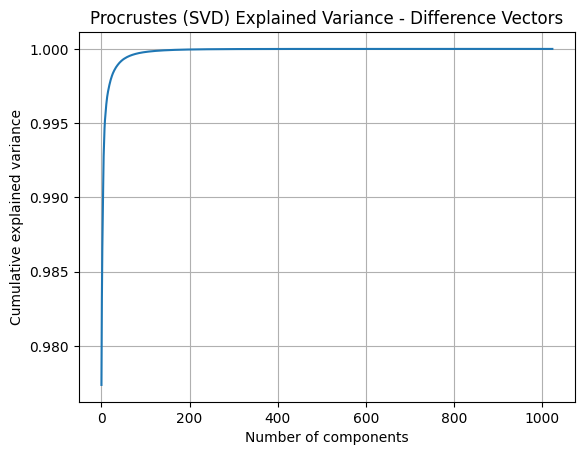

In [89]:
# Proportion of variance explained by each component
plt.plot(np.cumsum(S**2) / s_total)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Procrustes (SVD) Explained Variance - Difference Vectors")
plt.grid()
plt.savefig("plots/procrustes_explained_variance.png", dpi=300)
plt.show()

In [90]:
import random

research_dois = set(examples.target_doi)
print(research_dois)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def negative_vectors(example: pd.Series, n=5):
    # Get all target DOIs for this example, sample from those not cited
    rows = examples[(examples.source_doi == example.source_doi) & (examples.sent_idx == example.sent_idx)]
    citation_dois = set(rows.target_doi)
    neg_dois = list(research_dois - citation_dois)
    neg_samples = random.sample(neg_dois, n)
    
    # Get vectors for negative samples
    neg_vectors = np.zeros((n, embedder.dim))
    for i, doi in enumerate(neg_samples):
        records = db.select_by_doi(doi, collection_name="qwen06_chunks")
        sample_record = records.sample(n=1).iloc[0]
        neg_vectors[i] = np.array(sample_record['vector'])
    return neg_vectors

{'10.1088/0004-637X/718/2/774', '10.1086/186651', '10.1086/523960', '10.1111/j.1365-2966.2010.17112.x', '10.1046/j.1365-8711.2002.05995.x', '10.1016/j.jqsrt.2011.11.004', '10.1038/20867', '10.1086/191669', '10.1088/0004-637X/706/2/1341', '10.1086/431973', '10.1086/510833', '10.1086/518001', '10.1111/j.1365-2966.2006.10182.x', '10.1086/165059', '10.1086/174879', '10.1093/mnras/stw255', '10.1086/308868', '10.1093/mnras/stt504', '10.1038/s41586-020-2979-0', '10.1038/nature08557', '10.1086/307152', '10.1051/0004-6361:20042185', '10.1103/PhysRevD.96.123514', '10.1103/PhysRevLett.101.231301', '10.1086/156984', '10.1088/0067-0049/210/1/11', '10.1111/j.1365-2966.2003.07170.x', '10.48550/arXiv.astro-ph/0304150', '10.1051/0004-6361/201220196', '10.1051/0004-6361:20021220', '10.1086/149138', '10.1051/0004-6361:20041732', '10.1089/ast.2007.0209', '10.1088/0004-637X/783/2/134', '10.1088/0004-637X/720/1/344', '10.1086/300924', '10.1093/mnras/263.2.360', '10.1111/j.1365-2966.2004.07438.x', '10.1086/1

Citation DOIs: {'10.1046/j.1365-8711.2000.03810.x', '10.1086/316394', '10.1086/186883'}

In [94]:
differences_to_target = []
differences_to_negative = []
for _, row in examples.iterrows():
    query_vector = row['vector']
    target_vector = most_similar_to_query(row)
    aligned_query_vector = query_vector @ R
    before = cosine_similarity(query_vector, target_vector)
    after = cosine_similarity(aligned_query_vector, target_vector)

    differences_to_target.append(after - before)
    neg_vectors = negative_vectors(row, n=5)
    batch_distance_to_negative = []
    for neg_vector in neg_vectors:
        before_neg = cosine_similarity(query_vector, neg_vector)
        after_neg = cosine_similarity(aligned_query_vector, neg_vector)
        batch_distance_to_negative.append(after_neg - before_neg)
        differences_to_negative.append(after_neg - before_neg)
    print(_)
    print(f"Improvement to target: {after - before:.4f}")
    print(f"Distance to negatives: {np.mean(batch_distance_to_negative):.4f} ± {np.std(batch_distance_to_negative):.4f}")
    print("---")
print(f"Average improvement (target): {np.mean(differences_to_target):.6f} ± {np.std(differences_to_target):.6f}")
print(f"Average improvement (negative): {np.mean(differences_to_negative):.6f} ± {np.std(differences_to_negative):.6f}")

0
Improvement to target: 0.0033
Distance to negatives: 0.0094 ± 0.0075
---
1
Improvement to target: -0.0003
Distance to negatives: -0.0018 ± 0.0081
---
2
Improvement to target: 0.0256
Distance to negatives: 0.0010 ± 0.0105
---
3
Improvement to target: 0.0186
Distance to negatives: 0.0040 ± 0.0088
---
4
Improvement to target: 0.0111
Distance to negatives: -0.0042 ± 0.0092
---
5
Improvement to target: 0.0256
Distance to negatives: -0.0036 ± 0.0084
---
6
Improvement to target: -0.0042
Distance to negatives: 0.0069 ± 0.0089
---
7
Improvement to target: -0.0010
Distance to negatives: 0.0090 ± 0.0087
---
8
Improvement to target: 0.0138
Distance to negatives: 0.0014 ± 0.0075
---
9
Improvement to target: -0.0094
Distance to negatives: 0.0105 ± 0.0031
---
10
Improvement to target: 0.0220
Distance to negatives: 0.0098 ± 0.0078
---
11
Improvement to target: 0.0053
Distance to negatives: 0.0122 ± 0.0092
---
12
Improvement to target: 0.0070
Distance to negatives: 0.0083 ± 0.0061
---
13
Improvement 

In [ ]:
# Convert difference vectors to spherical coordinates
difference_vectors = T - Q


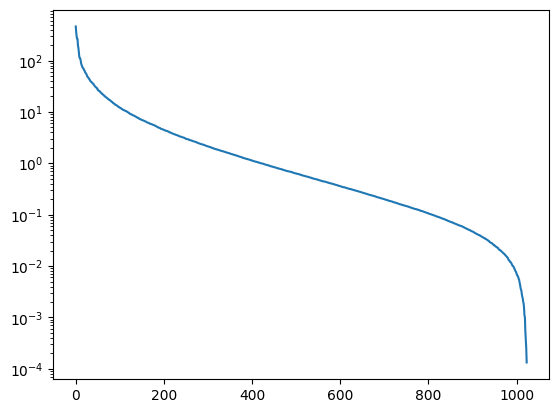

In [ ]:
# U, S, Vt = np.linalg.svd(M)
# print("U shape:", U.shape)
# print("S shape:", S.shape)
# print("Vt shape:", Vt.shape)
# print("Vt_trunc shape:", Vt[:1, :].shape)
# print("S_trunc shape:", S[:1].shape)
# print("U_trunc shape:", U[:, 0:1].shape)
# trunc = U[:, 0:1] @ (S[:1] * Vt[0:1, :])
# print("trunc shape:", trunc.shape)
# print("trunc rank:", np.linalg.matrix_rank(trunc))
# print(trunc)


plt.semilogy(S)  # plot singular values

In [ ]:
np.save('qwen06_chunks_rotation_n2000.npy', R)

In [ ]:
sigma1 = S[0]
eps = 1e-6  # try 1e-6 .. 1e-8 as needed
r = 50
# r = np.searchsorted(S / sigma1 < eps, True)  # first index where ratio < eps
print(f"Chosen rank r: {r}")
if r == 0:
    r = len(S)  # fallback if no small ones found
# alternative: r = np.searchsorted(np.cumsum(S**2) / np.sum(S**2), 0.99) + 1

# build small rotation in top-r
Ur = U[:, :r]  # n x r
Vr = Vt[:r, :].T  # n x r  (since Vt[:r,:] is r x n)
Msmall = Ur.T @ M @ Vr  # should be r x r but simpler compute: Tproj.T @ Qproj if you had them
# simpler: compute r x r cross-covariance directly via projections:
# Qproj = Q_all @ Ur  # expensive if many, but doable; here we reuse M decomposition
# but we can use SVD of the small Mslice: compute Us, Ss, Vts = svd(Ur.T @ M @ Vr)

# directly SVD the r x r matrix (numerically stable):
Us, Ss, Vts = np.linalg.svd(Ur.T @ M @ Vr, full_matrices=False)
Rsmall = Us @ Vts
# ensure proper rotation (det +1)
if np.linalg.det(Rsmall) < 0:
    D = np.eye(r)
    D[-1, -1] = -1
    Rsmall = Us @ D @ Vts

# map basis Ur to rotated basis Ur @ Rsmall @ Ur.T, then add identity on complement
R_full = Ur @ Rsmall @ Ur.T + (np.eye(1024) - Ur @ Ur.T)
print("det R_full:", np.linalg.det(R_full))
print(R_full.shape)
print(R_full)

In [93]:
np.save('qwen06_chunks_newR.npy', R)

Explained variance ratios (first 10): [0.01240934 0.01170661 0.01086627 0.01000957 0.00960797 0.00932786
 0.00902922 0.0088636  0.00853971 0.00806176]
Cumulative explained variance (first 10): [0.01240934 0.02411595 0.03498223 0.04499179 0.05459976 0.06392762
 0.07295683 0.08182044 0.09036015 0.09842191]


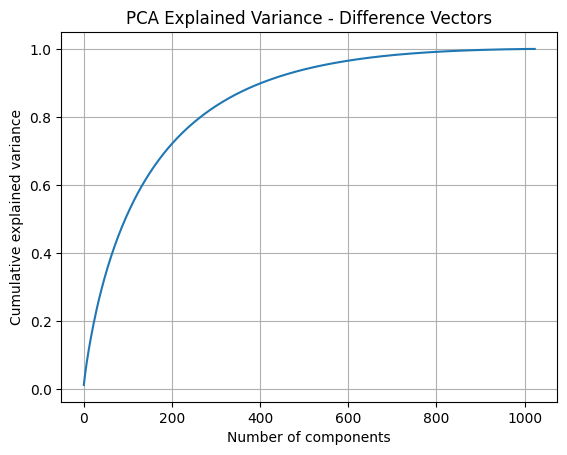

In [80]:
# Plot variance explained
pca_full = PCA()
pca_full.fit(difference_vectors)
print("Explained variance ratios (first 10):", pca_full.explained_variance_ratio_[:10])
print("Cumulative explained variance (first 10):", np.cumsum(pca_full.explained_variance_ratio_)[:10])
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance - Difference Vectors")
plt.grid()
# plt.savefig("plots/pca_explained_variance.png", dpi=300)
plt.show()

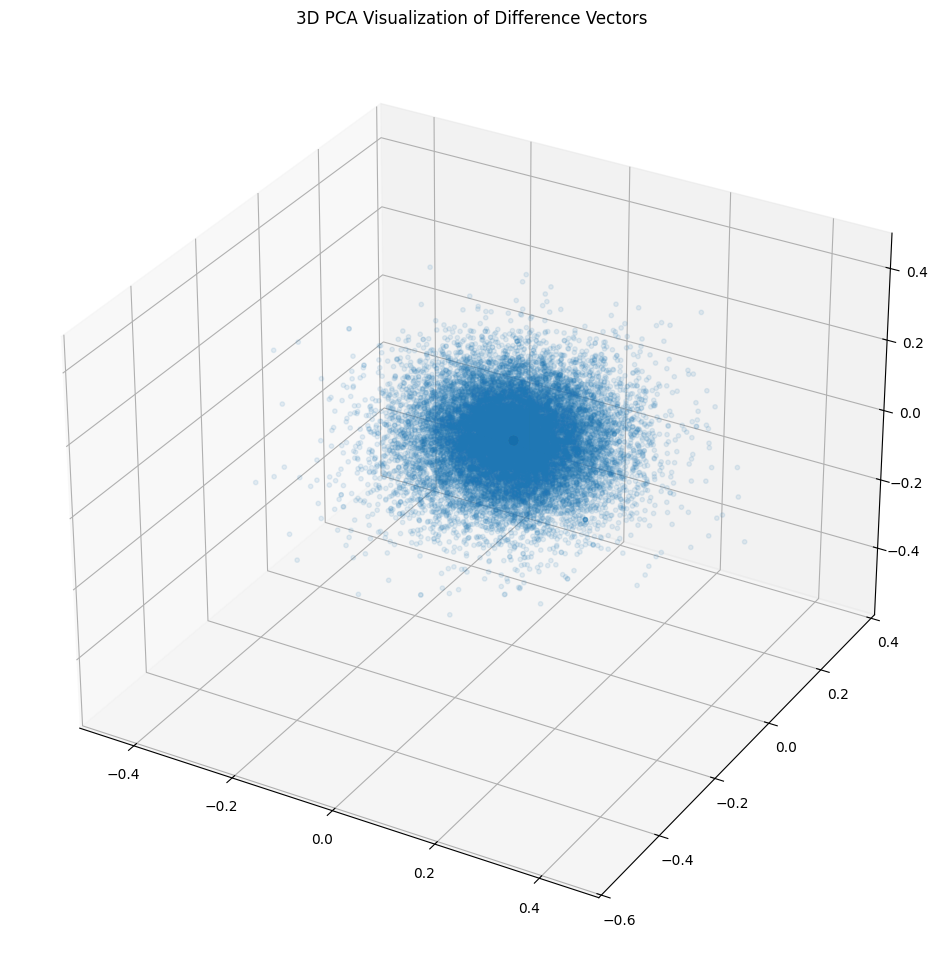

In [82]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(diffs_reduced[:, 0], diffs_reduced[:, 1], diffs_reduced[:, 2], s=10, alpha=0.1)
ax.scatter(0, 0, 0, color='black', s=40, label='Origin', alpha=1)
ax.set_title("3D PCA Visualization of Difference Vectors")
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.linalg import logm
from collections import defaultdict


# helper: minimal rotation mapping unit row-vector q -> unit row-vector t
def minimal_rotation_from_q_to_t(q, t, eps=1e-12):
    # q, t are 1D arrays, assumed unit (or close). returns dxd orthogonal rotation (det +1)
    d = q.shape[0]
    dot = float(np.dot(q, t))
    if dot > 1 - 1e-12:
        return np.eye(d)  # already aligned
    if dot < -1 + 1e-12:
        # antipodal: need a 180-degree rotation in some plane orth to q. pick arbitrary orth vector
        # find a vector orthogonal to q
        v = np.zeros_like(q)
        # choose index with smallest abs(q) to swap
        i = np.argmin(np.abs(q))
        v[i] = 1.0
        # make orthogonal
        v = v - np.dot(v, q) * q
        v /= np.linalg.norm(v)
        P = np.stack([q, v], axis=1)  # d x 2
        R2 = np.array([[-1.0, 0.0], [0.0, -1.0]])  # 180 deg in plane (maps q->-q, v->-v)
        R = np.eye(d) + P @ (R2 - np.eye(2)) @ P.T
        # We produced reflection twice -> det = +1
        return R

    # general case: build orthonormal basis for span{q,t}
    v = t - dot * q
    v_norm = np.linalg.norm(v)
    if v_norm < eps:
        return np.eye(d)
    e1 = q
    e2 = v / v_norm
    P = np.stack([e1, e2], axis=1)  # d x 2
    # 2x2 rotation that takes [1,0] -> [dot, v_norm]
    R2 = np.array([[dot, -v_norm], [v_norm, dot]])
    R = np.eye(d) + P @ (R2 - np.eye(2)) @ P.T
    return R


# Build R_i for each pair
Rs = []
n = Q.shape[0]
for i in range(n):
    Rs.append(minimal_rotation_from_q_to_t(Q[i], T[i]))
Rs = np.stack(Rs, axis=0)  # (n, d, d)

# Convert each R to compact vector via matrix logarithm (skew-symmetric)
vecs = []
use_logm = True
for i in range(n):
    R = Rs[i]
    try:
        L = logm(R)  # should be skew-symmetric for rotation matrices
        # ensure numeric real
        if np.max(np.abs(np.imag(L))) > 1e-6:
            L = np.real(L)
    except Exception:
        use_logm = False
        break
    # vectorize upper triangle (including diagonal if you want, diagonal should be ~0)
    iu = np.triu_indices(R.shape[0], k=1)
    vecs.append(L[iu].ravel())
if not use_logm:
    # fallback: use skew = (R - R.T)/2 as a proxy (also skew-symmetric)
    vecs = []
    for i in range(n):
        R = Rs[i]
        S = 0.5 * (R - R.T)
        iu = np.triu_indices(R.shape[0], k=1)
        vecs.append(S[iu].ravel())
vecs = np.stack(vecs, axis=0)  # (n, d*(d-1)/2)

# optional: reduce dimensionality for clustering
pca = PCA(n_components=min(50, vecs.shape[1], n - 1))
Z = pca.fit_transform(vecs)  # (n, p)

# cluster (try different K)
K = 4
kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(Z)
labels = kmeans.labels_

# Evaluate clusters: mean improvement and count
cluster_info = defaultdict(list)
for i, lab in enumerate(labels):
    before = np.dot(Q[i], T[i])  # they are unit or close; no normalization needed if unit
    after = np.dot((Q[i] @ Rs[i]) / np.linalg.norm(Q[i] @ Rs[i]), T[i])
    cluster_info[lab].append(after - before)

for lab in sorted(cluster_info.keys()):
    arr = np.array(cluster_info[lab])
    print(f"Cluster {lab}: n={len(arr)}, mean_improvement={arr.mean():.6f}, std={arr.std():.6f}")

# If you want to inspect representative pairs from each cluster:
for lab in range(K):
    idxs = np.where(labels == lab)[0]
    print("Cluster", lab, "example indices:", idxs[:5])